Ce fichier s'intéresse à la prédiction par régresseur Lasso. On a entrainé un modèle Lasso par client. Pour faire une prédiction, on utilise l'historique des données sur une semaine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm

In [2]:
def MSE(s0,s1):
    return np.mean((s0-s1)**2)

index_1821 = 1.0*np.array([(i>=18*2)*(i<=21*2) for i in range(48)])
def MSE_1821(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_1821
    s1_reindex = s1.reshape(-1,48)*index_1821
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_1821)

index_813 = 1.0*np.array([(i>=8*2)*(i<=13*2) for i in range(48)])
def MSE_813(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_813
    s1_reindex = s1.reshape(-1,48)*index_813
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_813)

In [3]:
calendrier_challenge = pd.read_parquet("Données/challenge_data/calendrier_challenge.parquet")
questionnaire = pd.read_parquet("Données/challenge_data/questionnaire.parquet")
consos_challenge = pd.read_parquet("Données/challenge_data/consos_challenge.parquet")
temperatures = pd.read_parquet("Données/challenge_data/temperatures.parquet")

In [73]:
min_date = datetime.datetime(2009,7,15)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
n_days = (max_date-min_date).days-365
client_challenges = np.array(questionnaire[questionnaire["participe_challenge"]==True].id_client)
id_client = client_challenges[0]

In [74]:
def load_signal(id_client,min_time,max_time):
    """
    Load the signal of client_id between min_time and max_time
    """
    data = consos_challenge[consos_challenge["id_client"]==id_client]
    data1 = data[data["horodate"]>min_time]
    return data1[data1["horodate"]<=max_time].puissance_W

# Prediction sur une journée

In [75]:
start_date = datetime.datetime(2009,7,15)

delta = 7*day
X_train = {}
y_train = {}
X_test = {}
y_test = {}
k=0

# Create the dataset
for client in tqdm(client_challenges):
    X_train[client]=[]
    y_train[client]=[]
    X_test[client]=[]
    y_test[client]=[]
    data_date = consos_challenge[consos_challenge["id_client"]==client]
    for i in range(365-8):
        y_inter = data_date[data_date["horodate"]>=start_date+delta+i*day]
        X_inter = data_date[data_date["horodate"]>=start_date+i*day]
        y_train[client].append(np.array(y_inter[y_inter["horodate"]<start_date+delta+(i+1)*day]['puissance_W']))
        X_train[client].append(np.array(X_inter[X_inter["horodate"]<start_date+delta+i*day]['puissance_W']))
    for i in range(365-8,n_days+365-8):
        y_inter = data_date[data_date["horodate"]>=start_date+delta+i*day]
        X_inter = data_date[data_date["horodate"]>=start_date+i*day]
        y_test[client].append(np.array(y_inter[y_inter["horodate"]<start_date+delta+(i+1)*day]['puissance_W']))
        X_test[client].append(np.array(X_inter[X_inter["horodate"]<start_date+delta+i*day]['puissance_W']))




100%|██████████| 307/307 [06:23<00:00,  1.25s/it]


In [76]:
from sklearn.linear_model import Lasso
Lasso_dict = {}

for client in tqdm(client_challenges):
    X = np.array(X_train[client])
    y = np.array(y_train[client])
    model=Lasso(0.05)
    model.fit(X,y)
    Lasso_dict[client]=model

100%|██████████| 307/307 [00:30<00:00, 10.13it/s]


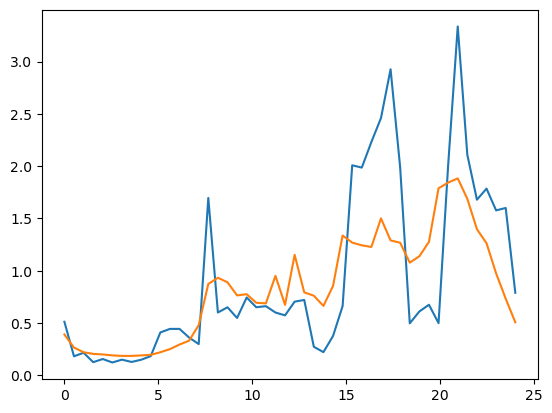

In [77]:
lasso_id = Lasso_dict[id_client]

X_t = np.array(X_test[id_client])
y_t = np.array(y_test[id_client])
y_predict = lasso_id.predict(X_t)
plt.plot(np.linspace(0,24,48),y_t[-30])
plt.plot(np.linspace(0,24,48),y_predict[-30])


0.4006753358337446 0.5947029384896915 0.4884446106029475


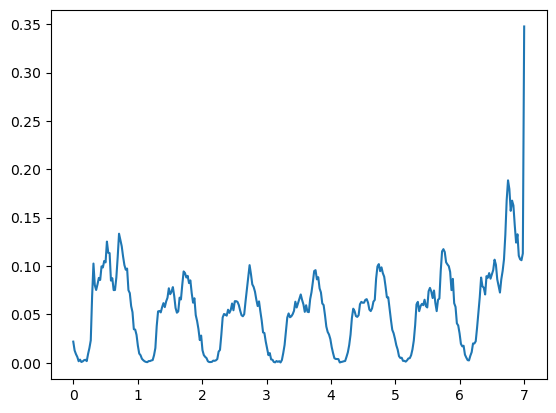

In [78]:
coefs = []
mse = []
MSE1821 = []
MSE813 = []
for client in client_challenges:
    coefs.append(np.abs(Lasso_dict[client].coef_).sum(axis=0))
    X_t = np.array(X_test[client])
    y_t = np.array(y_test[client])
    y_predict = lasso_id.predict(X_t)
    mse.append(MSE(y_t,y_predict))
    MSE1821.append(MSE_1821(y_t,y_predict))
    MSE813.append(MSE_813(y_t,y_predict))
print(np.mean(mse),np.mean(MSE1821),np.mean(MSE813))
plt.plot(np.linspace(0,7,48*7),np.mean(coefs,axis=0))
plt.show()


# Prédiction sur une plage horaire 18h-21h

In [79]:
#Données sur une semaine
start_date = datetime.datetime(2009,7,15,18)
hour = datetime.datetime(2009,7,15,2)-datetime.datetime(2009,7,15,1)

delta = 7*day
X_train2 = {}
y_train2 = {}
X_test2 = {}
y_test2 = {}
k=0
for client in tqdm(client_challenges):
    X_train2[client]=[]
    y_train2[client]=[]
    X_test2[client]=[]
    y_test2[client]=[]
    data_date = consos_challenge[consos_challenge["id_client"]==client]
    for i in range(365-8):
        y_inter = data_date[data_date["horodate"]>=start_date+delta+i*day]
        X_inter = data_date[data_date["horodate"]>=start_date+i*day]
        y_train2[client].append(np.array(y_inter[y_inter["horodate"]<=start_date+delta+(i)*day+3*hour]['puissance_W']))
        X_train2[client].append(np.array(X_inter[X_inter["horodate"]<start_date+delta+i*day]['puissance_W']))
    for i in range(365-8,n_days+365-8):
        y_inter = data_date[data_date["horodate"]>=start_date+delta+i*day]
        X_inter = data_date[data_date["horodate"]>=start_date+i*day]
        y_test2[client].append(np.array(y_inter[y_inter["horodate"]<=start_date+delta+(i)*day+3*hour]['puissance_W']))
        X_test2[client].append(np.array(X_inter[X_inter["horodate"]<start_date+delta+i*day]['puissance_W']))

100%|██████████| 307/307 [06:33<00:00,  1.28s/it]


In [80]:
from sklearn.linear_model import Lasso
Lasso_dict2 = {}

for client in tqdm(client_challenges):
    X = np.array(X_train2[client])
    y = np.array(y_train2[client])
    model=Lasso(0.05)
    model.fit(X,y)
    Lasso_dict2[client]=model

100%|██████████| 307/307 [00:06<00:00, 44.41it/s]


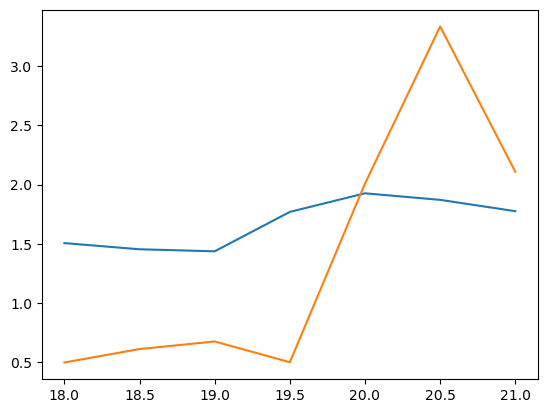

In [81]:
lasso_id = Lasso_dict2[id_client]

X_t = np.array(X_test2[id_client])
y_t = np.array(y_test2[id_client])
y_predict = lasso_id.predict(X_t)
plt.plot(np.linspace(18,21,7),y_predict[-30])
plt.plot(np.linspace(18,21,7),y_t[-30])

0.5661700811469748


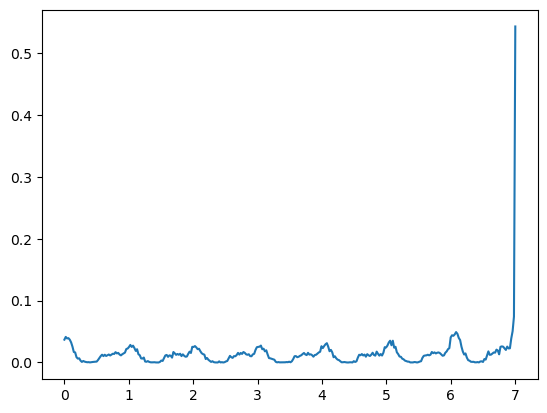

In [82]:
coefs = []
MSE1821 = []
for client in client_challenges:
    coefs.append(np.abs(Lasso_dict2[client].coef_).sum(axis=0))
    X_t = np.array(X_test2[client])
    y_t = np.array(y_test2[client])
    y_predict = lasso_id.predict(X_t)
    MSE1821.append(MSE(y_t,y_predict))
print(np.mean(MSE1821))
plt.plot(np.linspace(0,7,48*7),np.mean(coefs,axis=0))
plt.show()
